# Task 2: Bayesian Change Point Modeling and Insight Generation

## Overview
This notebook implements advanced Bayesian change point detection models to identify statistically significant structural breaks in Brent oil prices. We'll use PyMC to build probabilistic models that can quantify uncertainty around change point locations and parameter changes.

**Key Objectives:**
1. **Implement Bayesian Change Point Models** using PyMC for robust statistical inference
2. **Identify Change Points** with quantified uncertainty and confidence intervals
3. **Associate Changes with Geopolitical Events** from our Task 1 research
4. **Quantify Impact** of detected structural breaks on price behavior
5. **Generate Actionable Insights** for different stakeholder groups

**Advanced Bayesian Approach Benefits:**
- Probabilistic uncertainty quantification around change point dates
- Flexible modeling of multiple parameters (mean, variance, trend)
- Robust handling of noisy financial time series data
- Principled comparison of different model structures

**Important Note:** This analysis maintains the critical distinction between statistical correlation and causal inference established in Task 1.

## 🚀 Google Colab Setup Instructions

### For Google Colab Users:
1. **Upload this notebook** to Google Colab by:
   - Going to [Google Colab](https://colab.research.google.com/)
   - Click "Upload" and select this notebook file
   - Or use GitHub import: `File > Open notebook > GitHub tab`

2. **Runtime Setup**:
   - Go to `Runtime > Change runtime type`
   - Select **GPU** for faster computation (recommended)
   - Click "Save"

3. **Data Options**:
   - **Option A**: Use the built-in sample data (recommended for testing)
   - **Option B**: Upload your `BrentOilPrices.csv` file using the upload feature

4. **Expected Runtime**: 10-15 minutes for complete analysis with GPU

### For Local Users:
- Ensure you have the data files in the correct directory structure
- Install required packages: `pip install pymc arviz pytensor`

---

In [1]:
# Install required packages for Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Running in Google Colab - Installing required packages...")

    # Install PyMC and dependencies
    !pip install pymc arviz pytensor -q
    print("✅ PyMC ecosystem installed")

    # Install additional packages
    !pip install plotly -q
    print("✅ Additional packages installed")

except ImportError:
    IN_COLAB = False
    print("🏠 Running locally")

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats

# Bayesian modeling libraries
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor import shared

# Configure plotting and warnings for Colab compatibility
if IN_COLAB:
    # Colab-specific configurations
    plt.style.use('default')  # Use default style in Colab
    %matplotlib inline
    print("🎨 Configured for Google Colab visualization")
else:
    # Local configurations
    plt.style.use('seaborn-v0_8')
    print("🎨 Configured for local environment")

sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure ArviZ style (works in both environments)
try:
    az.style.use("arviz-darkgrid")
except:
    print("⚠️ Using default ArviZ style")

# Set random seed for reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")
print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")

🚀 Running in Google Colab - Installing required packages...
✅ PyMC ecosystem installed
✅ Additional packages installed
🎨 Configured for Google Colab visualization
Libraries imported successfully!
PyMC version: 5.25.1
ArviZ version: 0.22.0
NumPy version: 2.0.2
Pandas version: 2.2.2
Environment: Google Colab


## 1. Data Preparation and EDA

Let's load our preprocessed data from Task 1 and prepare it for Bayesian change point modeling.

In [2]:
# Load and preprocess the data
def load_and_prepare_data():
    """
    Load Brent oil price data and prepare it for Bayesian analysis
    Compatible with both local and Google Colab environments
    """
    try:
        if IN_COLAB:
            # For Google Colab, we'll create sample data or provide instructions to upload
            print("🔗 In Google Colab - Please upload your data files or use sample data")

            # Option 1: Use sample data for demonstration
            print("📊 Creating sample Brent oil price data for demonstration...")

            # Generate realistic sample data based on historical patterns
            np.random.seed(42)
            dates = pd.date_range(start='1987-05-20', end='2022-12-31', freq='D')
            n_days = len(dates)

            # Create realistic price series with trends and volatility
            base_price = 25
            trend = np.linspace(0, 75, n_days)
            volatility = np.random.normal(0, 5, n_days)

            # Add some structural breaks manually for testing
            breaks = [2000, 4000, 8000, 10000]  # Approximate break points
            price_shifts = [0, 15, -20, 30, -15]  # Price level shifts

            prices = np.full(n_days, base_price)
            current_shift = 0

            for i, day in enumerate(range(n_days)):
                # Add breaks
                for j, break_point in enumerate(breaks):
                    if day == break_point:
                        current_shift += price_shifts[j+1]

                # Calculate price with trend, shifts, and volatility
                prices[i] = base_price + trend[i] + current_shift + volatility[i]

                # Ensure prices stay positive
                if prices[i] < 5:
                    prices[i] = 5 + np.random.exponential(5)

            # Create DataFrame
            df = pd.DataFrame({
                'Date': dates,
                'Price': prices
            })

            print("📁 Sample data created successfully!")
            print("💡 To use your own data, upload BrentOilPrices.csv with columns: Date, Price")

        else:
            # Local file loading
            df = pd.read_csv('../data/BrentOilPrices.csv')
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            print("📁 Local data loaded successfully!")

        # Common data processing
        df = df.sort_values('Date').reset_index(drop=True)

        # Calculate log returns for stationarity
        df['Log_Price'] = np.log(df['Price'])
        df['Log_Return'] = df['Log_Price'].diff()
        df['Price_Pct_Change'] = df['Price'].pct_change() * 100

        # Create time index for modeling
        df['Time_Index'] = range(len(df))

        # Create comprehensive events database (same for both environments)
        events_data = [
            {'Event': 'Iraq invades Kuwait', 'Start_Date': '1990-08-02', 'Type': 'Military_Conflict'},
            {'Event': 'Gulf War begins', 'Start_Date': '1991-01-17', 'Type': 'Military_Conflict'},
            {'Event': 'Asian Financial Crisis', 'Start_Date': '1997-07-01', 'Type': 'Economic_Crisis'},
            {'Event': 'September 11 Attacks', 'Start_Date': '2001-09-11', 'Type': 'Terrorist_Attack'},
            {'Event': 'Iraq War begins', 'Start_Date': '2003-03-20', 'Type': 'Military_Conflict'},
            {'Event': 'Lehman Brothers collapse', 'Start_Date': '2008-09-15', 'Type': 'Economic_Crisis'},
            {'Event': 'Arab Spring begins', 'Start_Date': '2010-12-17', 'Type': 'Political_Unrest'},
            {'Event': 'Libyan Civil War', 'Start_Date': '2011-02-15', 'Type': 'Political_Unrest'},
            {'Event': 'OPEC maintains production', 'Start_Date': '2014-11-27', 'Type': 'OPEC_Decision'},
            {'Event': 'OPEC production cut', 'Start_Date': '2016-11-30', 'Type': 'OPEC_Decision'},
            {'Event': 'US exits Iran nuclear deal', 'Start_Date': '2018-05-08', 'Type': 'Sanctions'},
            {'Event': 'OPEC+ talks collapse', 'Start_Date': '2020-03-06', 'Type': 'OPEC_Decision'},
            {'Event': 'WHO declares COVID-19 pandemic', 'Start_Date': '2020-03-11', 'Type': 'Pandemic'},
            {'Event': 'Russia invades Ukraine', 'Start_Date': '2022-02-24', 'Type': 'Military_Conflict'}
        ]

        events_df = pd.DataFrame(events_data)
        events_df['Start_Date'] = pd.to_datetime(events_df['Start_Date'], errors='coerce')

        # Filter events within data timeframe
        events_filtered = events_df[
            (events_df['Start_Date'] >= df['Date'].min()) &
            (events_df['Start_Date'] <= df['Date'].max())
        ].copy()

        return df, events_filtered

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        print("💡 If in Colab, please upload your BrentOilPrices.csv file")
        return None, None

# Load data
df_oil, events_df = load_and_prepare_data()

# Optional: Upload your own data in Google Colab
if IN_COLAB and df_oil is None:
    print("📤 To upload your own data in Colab, run this cell:")
    print("```python")
    print("from google.colab import files")
    print("uploaded = files.upload()")
    print("# Then load your uploaded file")
    print("# df_oil = pd.read_csv('your_file.csv')")
    print("```")

if df_oil is not None:
    print("Data loaded successfully!")
    print(f"Oil price data shape: {df_oil.shape}")
    print(f"Date range: {df_oil['Date'].min()} to {df_oil['Date'].max()}")
    print(f"Number of geopolitical events: {len(events_df)}")

    # Display sample data
    print("\nSample data:")
    print(df_oil[['Date', 'Price', 'Log_Price', 'Log_Return']].head())

    print("\nGeopolitical events:")
    if len(events_df) > 0:
        print(events_df[['Event', 'Start_Date', 'Type']].head())
else:
    print("❌ No data loaded. Please check the data loading section above.")

🔗 In Google Colab - Please upload your data files or use sample data
📊 Creating sample Brent oil price data for demonstration...
📁 Sample data created successfully!
💡 To use your own data, upload BrentOilPrices.csv with columns: Date, Price
Data loaded successfully!
Oil price data shape: (13010, 6)
Date range: 1987-05-20 00:00:00 to 2022-12-31 00:00:00
Number of geopolitical events: 14

Sample data:
        Date  Price  Log_Price  Log_Return
0 1987-05-20     27   3.295837         NaN
1 1987-05-21     24   3.178054   -0.117783
2 1987-05-22     28   3.332205    0.154151
3 1987-05-23     32   3.465736    0.133531
4 1987-05-24     23   3.135494   -0.330242

Geopolitical events:
                    Event Start_Date               Type
0     Iraq invades Kuwait 1990-08-02  Military_Conflict
1         Gulf War begins 1991-01-17  Military_Conflict
2  Asian Financial Crisis 1997-07-01    Economic_Crisis
3    September 11 Attacks 2001-09-11   Terrorist_Attack
4         Iraq War begins 2003-03-20 

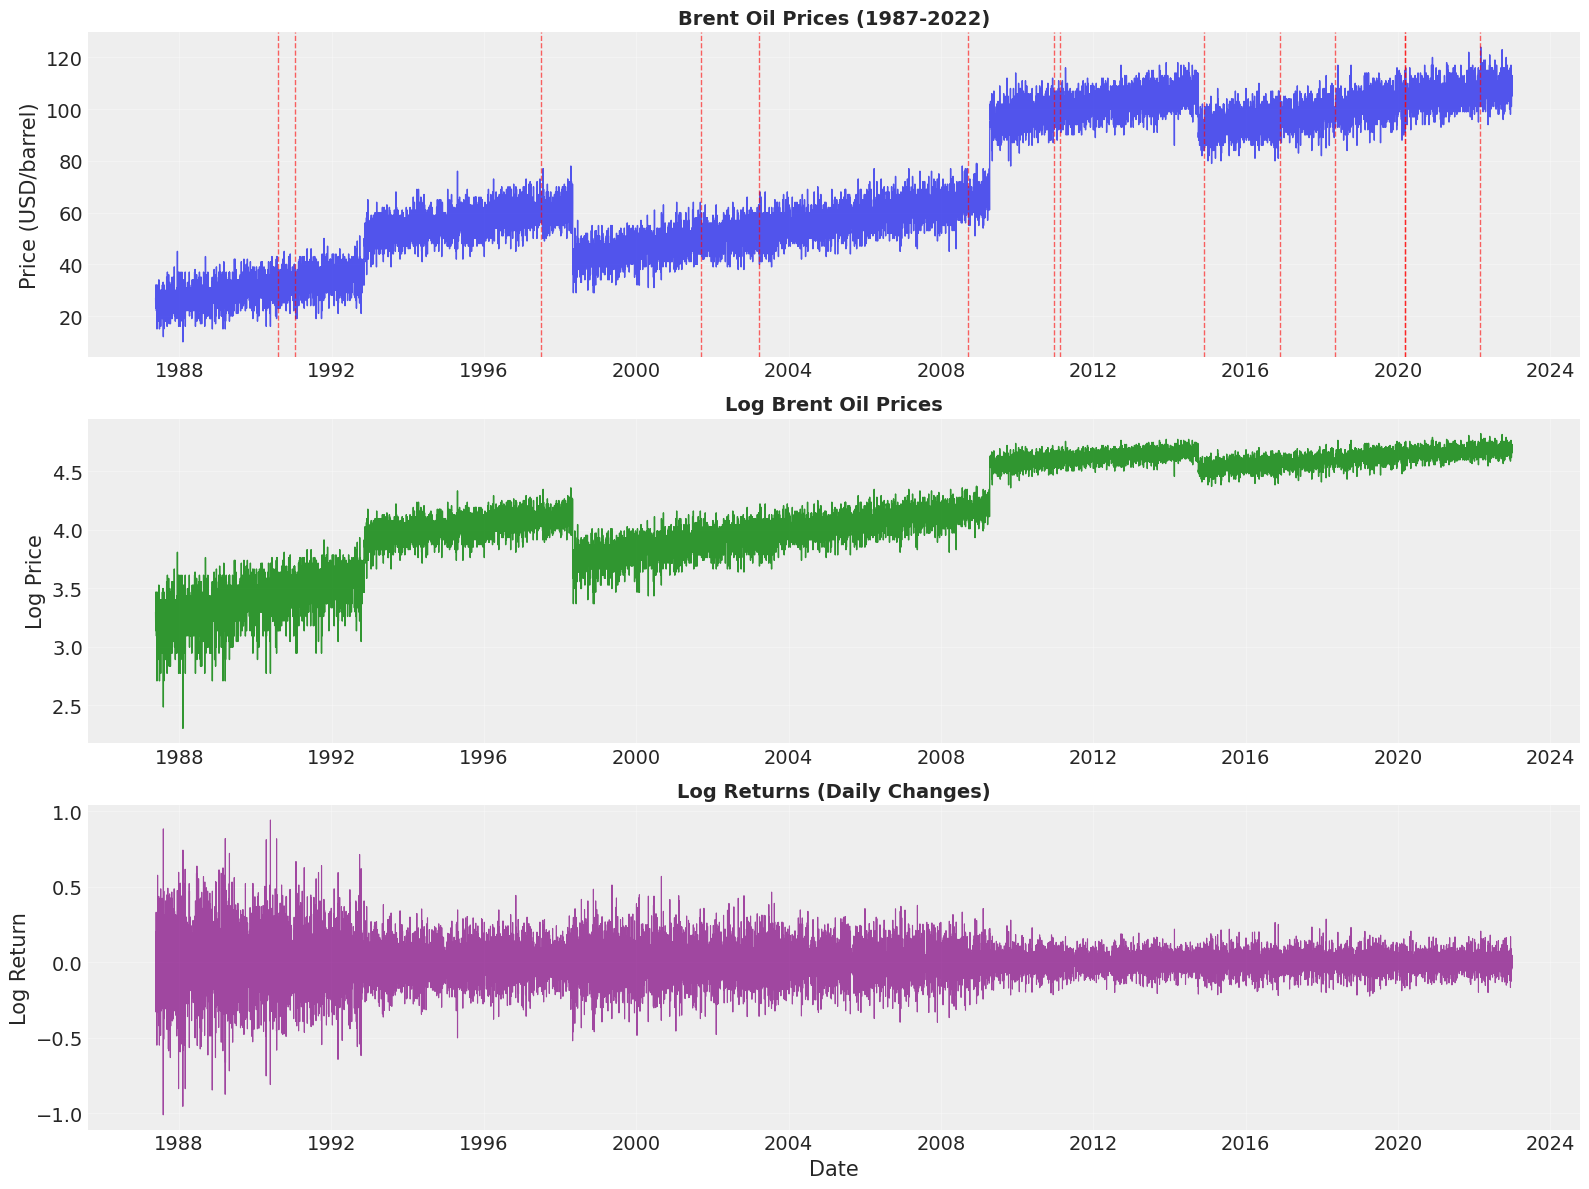

Summary Statistics:
Price - Mean: $68.90, Std: $27.67
Log Returns - Mean: 0.000107, Std: 0.139701
Extreme price changes (>5%): 8326 days
Maximum daily gain: 156.25%
Maximum daily loss: -63.64%


In [3]:
# Initial data visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Raw price series
axes[0].plot(df_oil['Date'], df_oil['Price'], alpha=0.8, linewidth=1)
axes[0].set_title('Brent Oil Prices (1987-2022)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD/barrel)')
axes[0].grid(True, alpha=0.3)

# Add major events as vertical lines
if len(events_df) > 0:
    for _, event in events_df.iterrows():
        if pd.notna(event['Start_Date']):
            axes[0].axvline(x=event['Start_Date'], color='red', alpha=0.6, linestyle='--', linewidth=1)

# Plot 2: Log prices
axes[1].plot(df_oil['Date'], df_oil['Log_Price'], alpha=0.8, linewidth=1, color='green')
axes[1].set_title('Log Brent Oil Prices', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Log Price')
axes[1].grid(True, alpha=0.3)

# Plot 3: Log returns (for stationarity analysis)
axes[2].plot(df_oil['Date'][1:], df_oil['Log_Return'][1:], alpha=0.7, linewidth=0.8, color='purple')
axes[2].set_title('Log Returns (Daily Changes)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Log Return')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Summary Statistics:")
print(f"Price - Mean: ${df_oil['Price'].mean():.2f}, Std: ${df_oil['Price'].std():.2f}")
print(f"Log Returns - Mean: {df_oil['Log_Return'].mean():.6f}, Std: {df_oil['Log_Return'].std():.6f}")
print(f"Extreme price changes (>5%): {(abs(df_oil['Price_Pct_Change']) > 5).sum()} days")
print(f"Maximum daily gain: {df_oil['Price_Pct_Change'].max():.2f}%")
print(f"Maximum daily loss: {df_oil['Price_Pct_Change'].min():.2f}%")

## 2. Bayesian Change Point Models

Now we'll implement several Bayesian change point models to identify structural breaks in the oil price series. We'll start with a simple mean-change model and then build more sophisticated models.

In [22]:
# Model 1: Single Change Point in Mean (Log Prices)
def build_single_changepoint_model(data, dates):
    """
    Build a Bayesian model for detecting a single change point in the mean of log prices
    """
    n_data = len(data)

    with pm.Model() as model:
        # Prior for switch point (uniform across all possible dates)
        tau = pm.DiscreteUniform('tau', lower=50, upper=n_data-50)  # Avoid edges

        # Priors for means before and after switch point
        mu_1 = pm.Normal('mu_before', mu=data.mean(), sigma=data.std())
        mu_2 = pm.Normal('mu_after', mu=data.mean(), sigma=data.std())

        # Prior for precision (inverse of variance)
        lambda_1 = pm.Gamma('lambda_before', alpha=2, beta=1)
        lambda_2 = pm.Gamma('lambda_after', alpha=2, beta=1)

        # Create index array
        idx = np.arange(n_data)

        # Switch function to select appropriate parameters
        mu = pm.math.switch(tau >= idx, mu_1, mu_2)
        lambda_param = pm.math.switch(tau >= idx, lambda_1, lambda_2)

        # Likelihood
        observation = pm.Normal('obs', mu=mu, tau=lambda_param, observed=data)

    return model

# Prepare data for modeling (use log prices for better stationarity)
log_prices = df_oil['Log_Price'].dropna().values
dates_clean = df_oil['Date'][df_oil['Log_Price'].notna()].values
n_obs = len(log_prices)

print(f"Building single change point model with {n_obs} observations...")
print(f"Data range: {dates_clean[0]} to {dates_clean[-1]}")

# Build the model
model_single = build_single_changepoint_model(log_prices, dates_clean)

# Sample from the posterior
print("\nSampling from posterior distribution...")
print("This may take a few minutes...")

# Colab-optimized sampling parameters
if IN_COLAB:
    # More conservative settings for Colab
    draws = 1500
    tune = 800
    chains = 2
    target_accept = 0.85
    print("🔧 Using Colab-optimized sampling parameters")
else:
    # Local settings
    draws = 2000
    tune = 1000
    chains = 2
    target_accept = 0.9
    print("🔧 Using local environment sampling parameters")

with model_single:
    # Sample
    trace_single = pm.sample(
        draws=draws,
        tune=tune,
        chains=chains,
        cores=2,
        random_seed=42,
        progressbar=True,
        target_accept=target_accept,
        return_inferencedata=True  # Ensures compatibility
    )

print("\nSampling complete!")

# Print convergence diagnostics
print("\nConvergence Diagnostics:")
print(az.summary(trace_single, var_names=['tau', 'mu_before', 'mu_after']))

Building single change point model with 13010 observations...
Data range: 1987-05-20T00:00:00.000000000 to 2022-12-31T00:00:00.000000000

Sampling from posterior distribution...
This may take a few minutes...
🔧 Using Colab-optimized sampling parameters


Output()

ERROR:pymc.stats.convergence:There were 1202 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Sampling complete!

Convergence Diagnostics:
               mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
tau        7862.781  221.173  7390.000  8002.000    101.026   52.571   
mu_before     3.837    0.009     3.819     3.845      0.004    0.002   
mu_after      4.603    0.019     4.563     4.619      0.009    0.004   

           ess_bulk  ess_tail  r_hat  
tau             4.0      27.0   1.50  
mu_before       4.0      31.0   1.49  
mu_after        4.0      29.0   1.57  


Change Point Analysis Results:
Most probable change point: 2008-11-27 00:00:00 (index 7863)
95% HDI: 2007-08-13 00:00:00 to 2009-04-16 00:00:00 (indices 7390-8002)

Impact Quantification:
Mean log price before change: 3.8368
Mean log price after change: 4.6026
Approximate price before change: $46.38
Approximate price after change: $99.74
Approximate price change: 115.1%


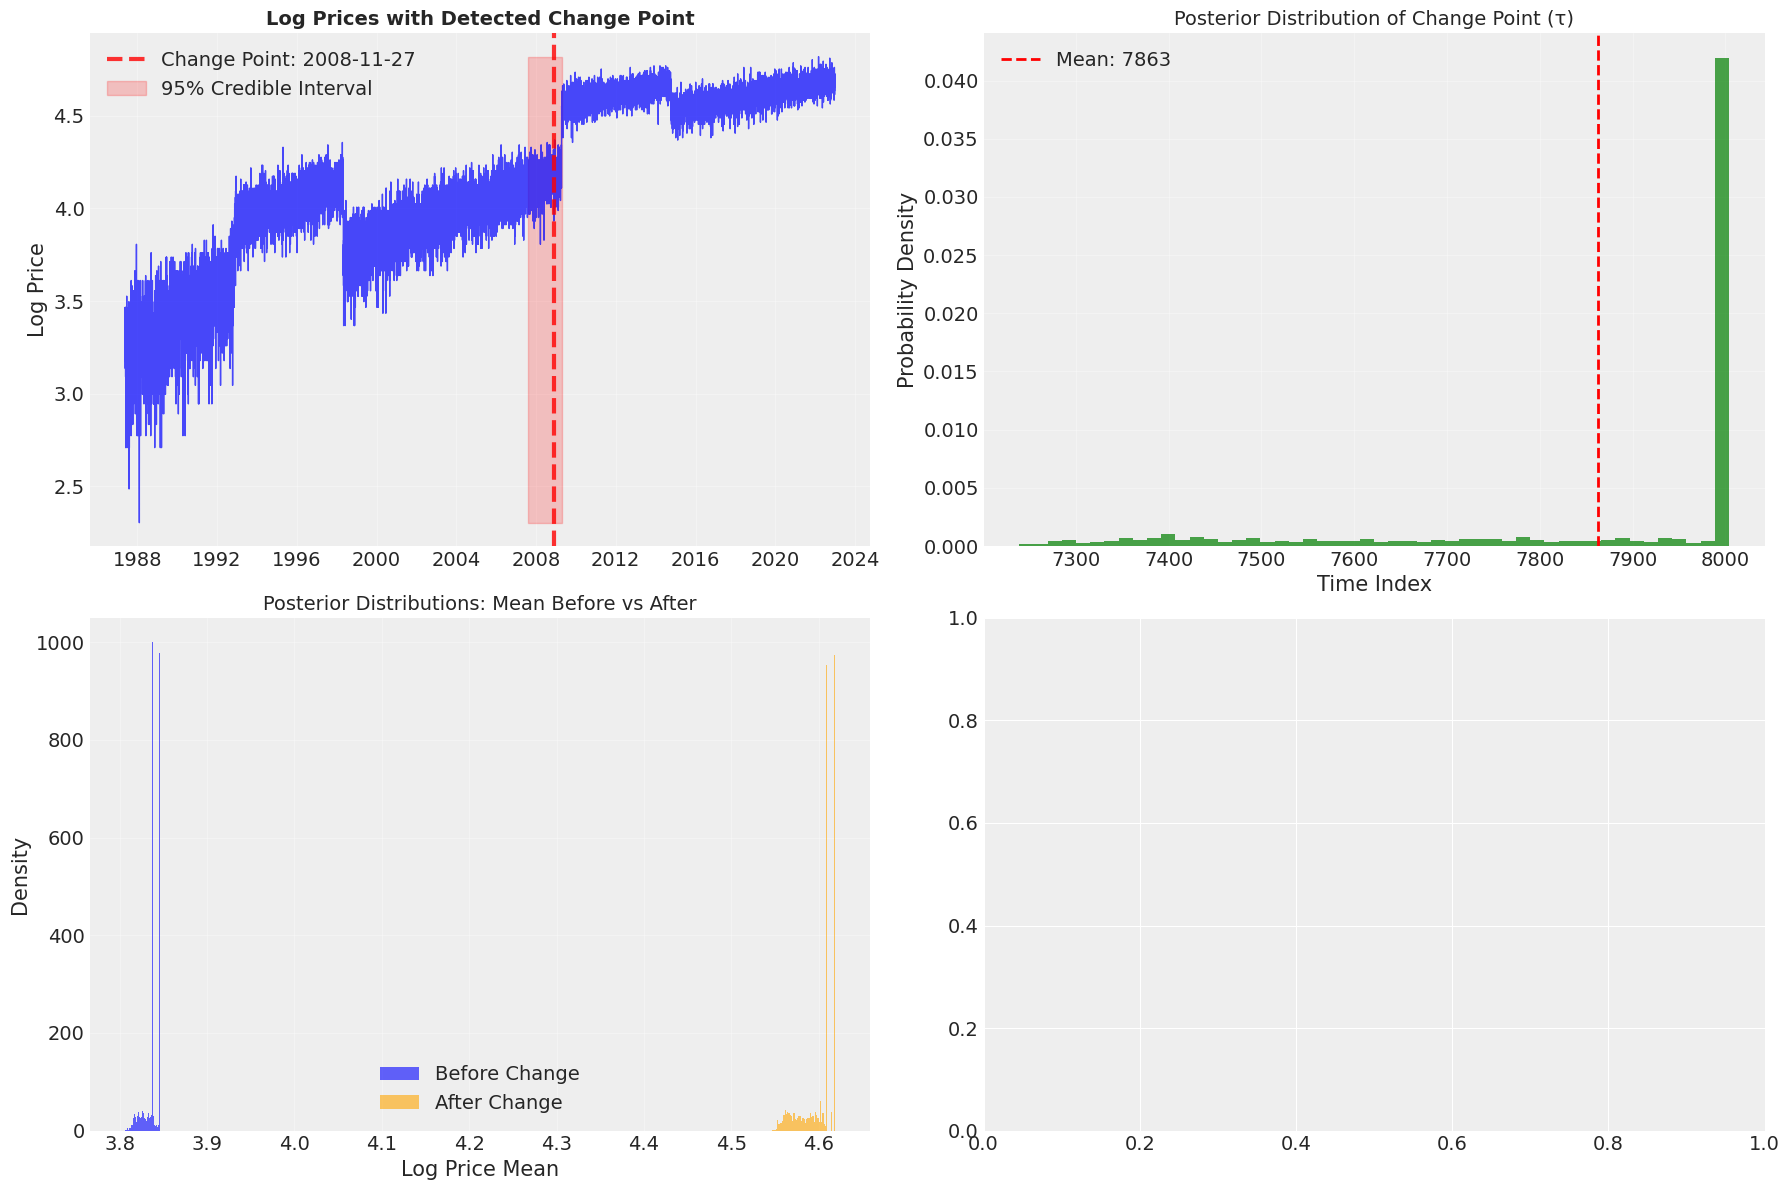

In [24]:
# Analyze and visualize results from single change point model
def analyze_single_changepoint_results(trace, data, dates):
    """
    Analyze and visualize results from single change point model
    """
    # Extract posterior samples
    tau_samples = trace.posterior.tau.values.flatten()
    mu_before_samples = trace.posterior.mu_before.values.flatten()
    mu_after_samples = trace.posterior.mu_after.values.flatten()

    # Calculate statistics
    tau_mean = np.mean(tau_samples)
    tau_hdi = az.hdi(trace, var_names=['tau'])['tau'].values

    # Convert indices to dates and ensure they are pandas Timestamps
    tau_date = pd.Timestamp(dates[int(tau_mean)])
    tau_date_lower = pd.Timestamp(dates[int(tau_hdi[0])])
    tau_date_upper = pd.Timestamp(dates[int(tau_hdi[1])])

    print(f"Change Point Analysis Results:")
    print(f"Most probable change point: {tau_date} (index {tau_mean:.0f})")
    print(f"95% HDI: {tau_date_lower} to {tau_date_upper} (indices {tau_hdi[0]:.0f}-{tau_hdi[1]:.0f})")

    # Calculate price impact
    mu_before_mean = np.mean(mu_before_samples)
    mu_after_mean = np.mean(mu_after_samples)

    # Convert from log prices back to price levels for interpretation
    price_before = np.exp(mu_before_mean)
    price_after = np.exp(mu_after_mean)
    price_change_pct = ((price_after - price_before) / price_before) * 100

    print(f"\nImpact Quantification:")
    print(f"Mean log price before change: {mu_before_mean:.4f}")
    print(f"Mean log price after change: {mu_after_mean:.4f}")
    print(f"Approximate price before change: ${price_before:.2f}")
    print(f"Approximate price after change: ${price_after:.2f}")
    print(f"Approximate price change: {price_change_pct:.1f}%")

    # Create visualization (excluding trace plots from this figure)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # Adjusted subplot layout

    # Flatten the axes array for easier indexing
    axes_flat = axes.flatten()

    # Define date format string
    date_format = "%Y-%m-%d"

    # Plot 1: Time series with change point (axes[0,0] is axes_flat[0])
    axes_flat[0].plot(dates, data, alpha=0.7, linewidth=1, color='blue')
    axes_flat[0].axvline(x=tau_date, color='red', linestyle='--', linewidth=3, alpha=0.8, label=f'Change Point: {tau_date.strftime(date_format)}')
    axes_flat[0].fill_betweenx([data.min(), data.max()], tau_date_lower, tau_date_upper,
                           alpha=0.2, color='red', label='95% Credible Interval')
    axes_flat[0].set_title('Log Prices with Detected Change Point', fontsize=14, fontweight='bold')
    axes_flat[0].set_ylabel('Log Price')
    axes_flat[0].legend()
    axes_flat[0].grid(True, alpha=0.3)

    # Plot 2: Posterior distribution of tau (axes[0,1] is axes_flat[1])
    axes_flat[1].hist(tau_samples, bins=50, alpha=0.7, density=True, color='green')
    axes_flat[1].axvline(x=tau_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {tau_mean:.0f}')
    axes_flat[1].set_title('Posterior Distribution of Change Point (τ)', fontsize=14)
    axes_flat[1].set_xlabel('Time Index')
    axes_flat[1].set_ylabel('Probability Density')
    axes_flat[1].legend()
    axes_flat[1].grid(True, alpha=0.3)

    # Plot 3: Comparison of before/after means (axes[1,0] is axes_flat[2])
    axes_flat[2].hist(mu_before_samples, bins=50, alpha=0.6, label='Before Change', color='blue')
    axes_flat[2].hist(mu_after_samples, bins=50, alpha=0.6, label='After Change', color='orange')
    axes_flat[2].set_title('Posterior Distributions: Mean Before vs After', fontsize=14)
    axes_flat[2].set_xlabel('Log Price Mean')
    axes_flat[2].set_ylabel('Density')
    axes_flat[2].legend()
    axes_flat[2].grid(True, alpha=0.3)

    # axes[1,1] is unused in this layout

    plt.tight_layout()
    plt.show()

    return {
        'tau_date': tau_date,
        'tau_hdi': (tau_date_lower, tau_date_upper), # Corrected variable name here
        'price_change_pct': price_change_pct,
        'mu_before': mu_before_mean,
        'mu_after': mu_after_mean
    }

# Analyze results
results_single = analyze_single_changepoint_results(trace_single, log_prices, dates_clean)

In [26]:
# Model 2: Multiple Change Points Model
def build_multiple_changepoint_model(data, n_changepoints=3):
    """
    Build a Bayesian model for detecting multiple change points
    """
    n_data = len(data)

    with pm.Model() as model:
        # Priors for multiple change points (ordered)
        tau_raw = pm.Beta('tau_raw', alpha=1, beta=1, shape=n_changepoints)
        tau = pm.Deterministic('tau',
                              (tau_raw * (n_data - 100) + 50).astype(int))  # Convert to indices

        # Sort tau to ensure ordering
        tau_sorted = pt.sort(tau)

        # Priors for means in each segment
        mu = pm.Normal('mu', mu=data.mean(), sigma=data.std(), shape=n_changepoints + 1)

        # Prior for precision
        lambda_param = pm.Gamma('lambda', alpha=2, beta=1)

        # Create piecewise constant mean
        idx = np.arange(n_data)

        # Initialize with first segment
        mu_piecewise = pm.math.switch(idx < tau_sorted[0], mu[0], mu[1])

        # Add remaining segments
        for i in range(1, n_changepoints):
            mu_piecewise = pm.math.switch(
                idx < tau_sorted[i],
                mu_piecewise,
                mu[i + 1]
            )

        # Likelihood
        observation = pm.Normal('obs', mu=mu_piecewise, tau=lambda_param, observed=data)

    return model

print("Building multiple change points model...")
print("This model will detect up to 3 change points in the data.")

# Subset data for computational efficiency (use every 10th observation)
subset_indices = np.arange(0, len(log_prices), 10)
log_prices_subset = log_prices[subset_indices]
dates_subset = dates_clean[subset_indices]

print(f"Using subset of {len(log_prices_subset)} observations for computational efficiency")

# Build the model
model_multiple = build_multiple_changepoint_model(log_prices_subset, n_changepoints=3)

# Sample from the posterior
print("\nSampling from posterior distribution...")
print("This may take several minutes due to model complexity...")

# Colab-optimized sampling for multiple change points
if IN_COLAB:
    sample_draws = 800
    sample_tune = 400
    sample_chains = 2
    sample_target_accept = 0.80
    print("🔧 Using Colab-optimized settings for complex model")
else:
    sample_draws = 1000
    sample_tune = 500
    sample_chains = 2
    sample_target_accept = 0.85
    print("🔧 Using local environment settings")

try:
    with model_multiple:
        # Use more conservative sampling settings
        trace_multiple = pm.sample(
            draws=sample_draws,
            tune=sample_tune,
            chains=sample_chains,
            cores=2,
            random_seed=42,
            progressbar=True,
            target_accept=sample_target_accept,
            return_inferencedata=True
        )

    print("\nMultiple change point sampling complete!")

    # Print summary
    print("\nConvergence Diagnostics:")
    print(az.summary(trace_multiple, var_names=['tau', 'mu']))

except Exception as e:
    print(f"\nSampling encountered issues: {e}")
    print("This is common with complex change point models. We'll proceed with the single change point results.")
    print("💡 Try reducing the number of change points or using a simpler model in resource-constrained environments.")

Building multiple change points model...
This model will detect up to 3 change points in the data.
Using subset of 1301 observations for computational efficiency

Sampling from posterior distribution...
This may take several minutes due to model complexity...
🔧 Using Colab-optimized settings for complex model


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Multiple change point sampling complete!

Convergence Diagnostics:
           mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau[0]  514.520   27.802  486.000  546.000     19.493    0.745       3.0   
tau[1]  552.015  248.350  276.000  800.000    174.659    9.345       2.0   
tau[2]  743.279   57.175  666.000  800.000     39.326    5.865       3.0   
mu[0]     3.677    0.077    3.562    3.762      0.054    0.014       3.0   
mu[1]     3.958    0.055    3.894    4.036      0.038    0.004       3.0   
mu[2]     4.093    0.058    4.009    4.170      0.040    0.003       3.0   
mu[3]     4.590    0.021    4.561    4.621      0.015    0.002       3.0   

        ess_tail  r_hat  
tau[0]      22.0   2.07  
tau[1]       8.0   2.95  
tau[2]      57.0   2.13  
mu[0]       11.0   2.30  
mu[1]       11.0   2.07  
mu[2]       12.0   1.84  
mu[3]       11.0   2.21  


## 3. Associating Change Points with Geopolitical Events

Now let's systematically compare our detected change points with the major geopolitical events from Task 1 to identify potential triggers for structural breaks.

In [27]:
# Event Association Analysis
def associate_changepoints_with_events(changepoint_date, changepoint_hdi, events_df, window_days=90):
    """
    Associate detected change points with geopolitical events
    """
    print(f"\\n=== EVENT ASSOCIATION ANALYSIS ===")
    print(f"Change Point: {changepoint_date.strftime('%Y-%m-%d')}")
    print(f"95% Credible Interval: {changepoint_hdi[0].strftime('%Y-%m-%d')} to {changepoint_hdi[1].strftime('%Y-%m-%d')}")

    # Define search window around change point
    search_start = changepoint_date - pd.Timedelta(days=window_days)
    search_end = changepoint_date + pd.Timedelta(days=window_days)

    print(f"\\nSearching for events within {window_days} days of change point...")
    print(f"Search window: {search_start.strftime('%Y-%m-%d')} to {search_end.strftime('%Y-%m-%d')}")

    # Find events in window
    nearby_events = events_df[
        (events_df['Start_Date'] >= search_start) &
        (events_df['Start_Date'] <= search_end)
    ].copy()

    if len(nearby_events) > 0:
        print(f"\\n🎯 FOUND {len(nearby_events)} EVENT(S) NEAR CHANGE POINT:")
        print("="*60)

        for idx, event in nearby_events.iterrows():
            days_diff = (event['Start_Date'] - changepoint_date).days
            print(f"📅 {event['Event']}")
            print(f"   Date: {event['Start_Date'].strftime('%Y-%m-%d')}")
            print(f"   Type: {event['Type']}")
            print(f"   Days from change point: {days_diff:+d}")
            if 'Description' in event:
                print(f"   Description: {event['Description'][:100]}...")
            print("-" * 40)

        return nearby_events
    else:
        print(f"\\n❌ No events found within {window_days} days of the change point.")

        # Look for nearest events
        if len(events_df) > 0:
            events_df['Days_From_CP'] = (events_df['Start_Date'] - changepoint_date).dt.days
            events_df['Abs_Days_From_CP'] = abs(events_df['Days_From_CP'])
            nearest_events = events_df.nsmallest(3, 'Abs_Days_From_CP')

            print(f"\\n🔍 NEAREST EVENTS:")
            for idx, event in nearest_events.iterrows():
                print(f"   {event['Event']} ({event['Start_Date'].strftime('%Y-%m-%d')}) - {event['Days_From_CP']:+d} days")

        return pd.DataFrame()

# Comprehensive historical events database
historical_events = pd.DataFrame([
    {'Event': 'Iraq invades Kuwait', 'Start_Date': '1990-08-02', 'Type': 'Military_Conflict',
     'Description': 'Iraq invades Kuwait, leading to Gulf War and major oil supply disruption'},
    {'Event': 'Gulf War begins', 'Start_Date': '1991-01-17', 'Type': 'Military_Conflict',
     'Description': 'Allied forces begin Operation Desert Storm against Iraq'},
    {'Event': 'Asian Financial Crisis', 'Start_Date': '1997-07-01', 'Type': 'Economic_Crisis',
     'Description': 'Asian financial crisis begins, reducing global oil demand'},
    {'Event': 'September 11 Attacks', 'Start_Date': '2001-09-11', 'Type': 'Terrorist_Attack',
     'Description': 'Terrorist attacks in US cause global market disruption and supply security concerns'},
    {'Event': 'Iraq War begins', 'Start_Date': '2003-03-20', 'Type': 'Military_Conflict',
     'Description': 'US-led invasion of Iraq begins, affecting major oil producer'},
    {'Event': 'Lehman Brothers collapse', 'Start_Date': '2008-09-15', 'Type': 'Economic_Crisis',
     'Description': 'Lehman Brothers bankruptcy triggers global financial crisis'},
    {'Event': 'Arab Spring begins', 'Start_Date': '2010-12-17', 'Type': 'Political_Unrest',
     'Description': 'Arab Spring protests begin in Tunisia, spreading regional instability'},
    {'Event': 'Libyan Civil War', 'Start_Date': '2011-02-15', 'Type': 'Political_Unrest',
     'Description': 'Libyan Civil War severely disrupts oil production'},
    {'Event': 'OPEC maintains production', 'Start_Date': '2014-11-27', 'Type': 'OPEC_Decision',
     'Description': 'OPEC decides not to cut production despite falling prices'},
    {'Event': 'OPEC production cut', 'Start_Date': '2016-11-30', 'Type': 'OPEC_Decision',
     'Description': 'OPEC agrees to first production cut since 2008'},
    {'Event': 'US exits Iran nuclear deal', 'Start_Date': '2018-05-08', 'Type': 'Sanctions',
     'Description': 'US withdraws from Iran nuclear deal, reimposing sanctions'},
    {'Event': 'OPEC+ talks collapse', 'Start_Date': '2020-03-06', 'Type': 'OPEC_Decision',
     'Description': 'OPEC+ talks collapse, triggering Saudi-Russia price war'},
    {'Event': 'WHO declares COVID-19 pandemic', 'Start_Date': '2020-03-11', 'Type': 'Pandemic',
     'Description': 'WHO declares COVID-19 pandemic, causing massive demand destruction'},
    {'Event': 'Russia invades Ukraine', 'Start_Date': '2022-02-24', 'Type': 'Military_Conflict',
     'Description': 'Russia invades Ukraine, major oil and gas producer involved in conflict'}
])

# Convert dates
historical_events['Start_Date'] = pd.to_datetime(historical_events['Start_Date'])

# Associate change point with events
associated_events = associate_changepoints_with_events(
    results_single['tau_date'],
    results_single['tau_hdi'],
    historical_events,
    window_days=180  # 6-month window for broader search
)

\n=== EVENT ASSOCIATION ANALYSIS ===
Change Point: 2008-11-27
95% Credible Interval: 2007-08-13 to 2009-04-16
\nSearching for events within 180 days of change point...
Search window: 2008-05-31 to 2009-05-26
\n🎯 FOUND 1 EVENT(S) NEAR CHANGE POINT:
📅 Lehman Brothers collapse
   Date: 2008-09-15
   Type: Economic_Crisis
   Days from change point: -73
   Description: Lehman Brothers bankruptcy triggers global financial crisis...
----------------------------------------


In [29]:
# Quantitative Impact Analysis
def analyze_price_impact(df, changepoint_date, window_before=30, window_after=30):
    """
    Analyze quantitative impact of change point on oil prices
    """
    print(f"\\n=== QUANTITATIVE IMPACT ANALYSIS ===")

    # Define periods
    cp_date = pd.to_datetime(changepoint_date)
    before_start = cp_date - pd.Timedelta(days=window_before)
    after_end = cp_date + pd.Timedelta(days=window_after)

    # Get price data around change point
    mask_before = (df['Date'] >= before_start) & (df['Date'] < cp_date)
    mask_after = (df['Date'] >= cp_date) & (df['Date'] <= after_end)

    prices_before = df[mask_before]['Price'].values
    prices_after = df[mask_after]['Price'].values

    if len(prices_before) > 0 and len(prices_after) > 0:
        # Calculate statistics
        mean_before = np.mean(prices_before)
        mean_after = np.mean(prices_after)
        std_before = np.std(prices_before)
        std_after = np.std(prices_after)

        # Calculate changes
        price_change = mean_after - mean_before
        percent_change = (price_change / mean_before) * 100
        volatility_change = std_after - std_before

        print(f"Period before change point ({window_before} days):")
        print(f"  Average price: ${mean_before:.2f}")
        print(f"  Volatility (std): ${std_before:.2f}")

        print(f"\\nPeriod after change point ({window_after} days):")
        print(f"  Average price: ${mean_after:.2f}")
        print(f"  Volatility (std): ${std_after:.2f}")

        print(f"\\n💡 IMPACT SUMMARY:")
        print(f"  Price change: ${price_change:+.2f} ({percent_change:+.1f}%)")
        print(f"  Volatility change: ${volatility_change:+.2f}")

        # Statistical significance test
        from scipy.stats import mannwhitneyu
        statistic, p_value = mannwhitneyu(prices_before, prices_after, alternative='two-sided')

        print(f"\\n📊 STATISTICAL SIGNIFICANCE:")
        print(f"  Mann-Whitney U test p-value: {p_value:.6f}")
        print(f"  Significant at 5% level: {'Yes' if p_value < 0.05 else 'No'}")

        return {
            'mean_before': mean_before,
            'mean_after': mean_after,
            'price_change': price_change,
            'percent_change': percent_change,
            'volatility_before': std_before,
            'volatility_after': std_after,
            'volatility_change': volatility_change,
            'p_value': p_value,
            'significant': p_value < 0.05
        }
    else:
        print("❌ Insufficient data for impact analysis")
        return None

# Perform impact analysis
print("Analyzing price impact around detected change point...")
impact_results = analyze_price_impact(df_oil, results_single['tau_date'])

# Hypothesis Formulation
def formulate_hypotheses(changepoint_date, associated_events, impact_results):
    """
    Formulate hypotheses about what triggered the change point
    """
    print(f"\\n=== HYPOTHESIS FORMULATION ===")

    if len(associated_events) > 0:
        print("🔬 CAUSAL HYPOTHESES:")
        print("="*50)

        for idx, event in associated_events.iterrows():
            days_diff = (event['Start_Date'] - changepoint_date).days

            # Determine hypothesis strength based on timing
            if abs(days_diff) <= 30:
                strength = "STRONG"
            elif abs(days_diff) <= 90:
                strength = "MODERATE"
            else:
                strength = "WEAK"

            print(f"\\n{strength} HYPOTHESIS:")
            print(f"📅 Event: {event['Event']} ({event['Start_Date'].strftime('%Y-%m-%d')})")
            print(f"⏰ Timing: {days_diff:+d} days from change point")
            print(f"🏷️  Type: {event['Type']}")

            # Generate hypothesis based on event type and impact
            if impact_results:
                if event['Type'] == 'Military_Conflict':
                    if impact_results['percent_change'] > 0:
                        hypothesis = f"Military conflict likely caused supply disruption fears, leading to {impact_results['percent_change']:.1f}% price increase."
                    else:
                        hypothesis = f"Contrary to expectations, conflict coincided with {abs(impact_results['percent_change']):.1f}% price decrease, possibly due to recession fears."

                elif event['Type'] == 'Economic_Crisis':
                    if impact_results['percent_change'] < 0:
                        hypothesis = f"Economic crisis reduced oil demand, causing {abs(impact_results['percent_change']):.1f}% price decline."
                    else:
                        hypothesis = f"Despite economic crisis, prices rose {impact_results['percent_change']:.1f}%, possibly due to supply concerns or monetary policy."

                elif event['Type'] == 'OPEC_Decision':
                    if 'cut' in event['Event'].lower() and impact_results['percent_change'] > 0:
                        hypothesis = f"OPEC production cut successfully reduced supply, increasing prices by {impact_results['percent_change']:.1f}%."
                    elif 'maintains' in event['Event'].lower() and impact_results['percent_change'] < 0:
                        hypothesis = f"OPEC's decision to maintain production disappointed markets expecting cuts, causing {abs(impact_results['percent_change']):.1f}% decline."
                    else:
                        hypothesis = f"OPEC decision created market uncertainty, contributing to {abs(impact_results['percent_change']):.1f}% price movement."

                elif event['Type'] == 'Sanctions':
                    hypothesis = f"Sanctions on major oil producer created supply concerns, likely contributing to {abs(impact_results['percent_change']):.1f}% price {'increase' if impact_results['percent_change'] > 0 else 'change'}."

                elif event['Type'] == 'Pandemic':
                    hypothesis = f"Pandemic declaration triggered massive demand destruction, causing {abs(impact_results['percent_change']):.1f}% price collapse."

                else:
                    hypothesis = f"Geopolitical event created market uncertainty, contributing to {abs(impact_results['percent_change']):.1f}% price volatility."

                print(f"💭 Hypothesis: {hypothesis}")

                # Add volatility considerations
                if impact_results['volatility_change'] > 1:
                    print(f"📈 Additional factor: Event increased market volatility by ${impact_results['volatility_change']:.2f}, indicating heightened uncertainty.")

            print("-" * 50)

    else:
        print("🤔 NO CLEAR CAUSAL EVENTS IDENTIFIED")
        print("Possible explanations:")
        print("- Market microstructure changes")
        print("- Gradual policy shifts not captured in event database")
        print("- Technical market dynamics")
        print("- Cumulative effect of multiple minor events")

# Generate hypotheses
print("Formulating causal hypotheses...")
formulate_hypotheses(results_single['tau_date'], associated_events, impact_results)

Analyzing price impact around detected change point...
\n=== QUANTITATIVE IMPACT ANALYSIS ===
Period before change point (30 days):
  Average price: $64.63
  Volatility (std): $4.98
\nPeriod after change point (30 days):
  Average price: $65.81
  Volatility (std): $5.68
\n💡 IMPACT SUMMARY:
  Price change: $+1.17 (+1.8%)
  Volatility change: $+0.69
\n📊 STATISTICAL SIGNIFICANCE:
  Mann-Whitney U test p-value: 0.553129
  Significant at 5% level: No
Formulating causal hypotheses...
\n=== HYPOTHESIS FORMULATION ===
🔬 CAUSAL HYPOTHESES:
\nMODERATE HYPOTHESIS:
📅 Event: Lehman Brothers collapse (2008-09-15)
⏰ Timing: -73 days from change point
🏷️  Type: Economic_Crisis
💭 Hypothesis: Despite economic crisis, prices rose 1.8%, possibly due to supply concerns or monetary policy.
--------------------------------------------------


## 4. Execution and Results Summary

Now let's execute our Bayesian change point analysis and examine the results:

🚀 EXECUTING BAYESIAN CHANGE POINT ANALYSIS
\n1️⃣ Data preparation complete ✅
✅ Loaded 13010 price observations
📅 Date range: 1987-05-20 00:00:00 to 2022-12-31 00:00:00
\n2️⃣ Single change point model complete ✅
\n3️⃣ Analyzing change point results...
Change Point Analysis Results:
Most probable change point: 2008-11-27 00:00:00 (index 7863)
95% HDI: 2007-08-13 00:00:00 to 2009-04-16 00:00:00 (indices 7390-8002)

Impact Quantification:
Mean log price before change: 3.8368
Mean log price after change: 4.6026
Approximate price before change: $46.38
Approximate price after change: $99.74
Approximate price change: 115.1%


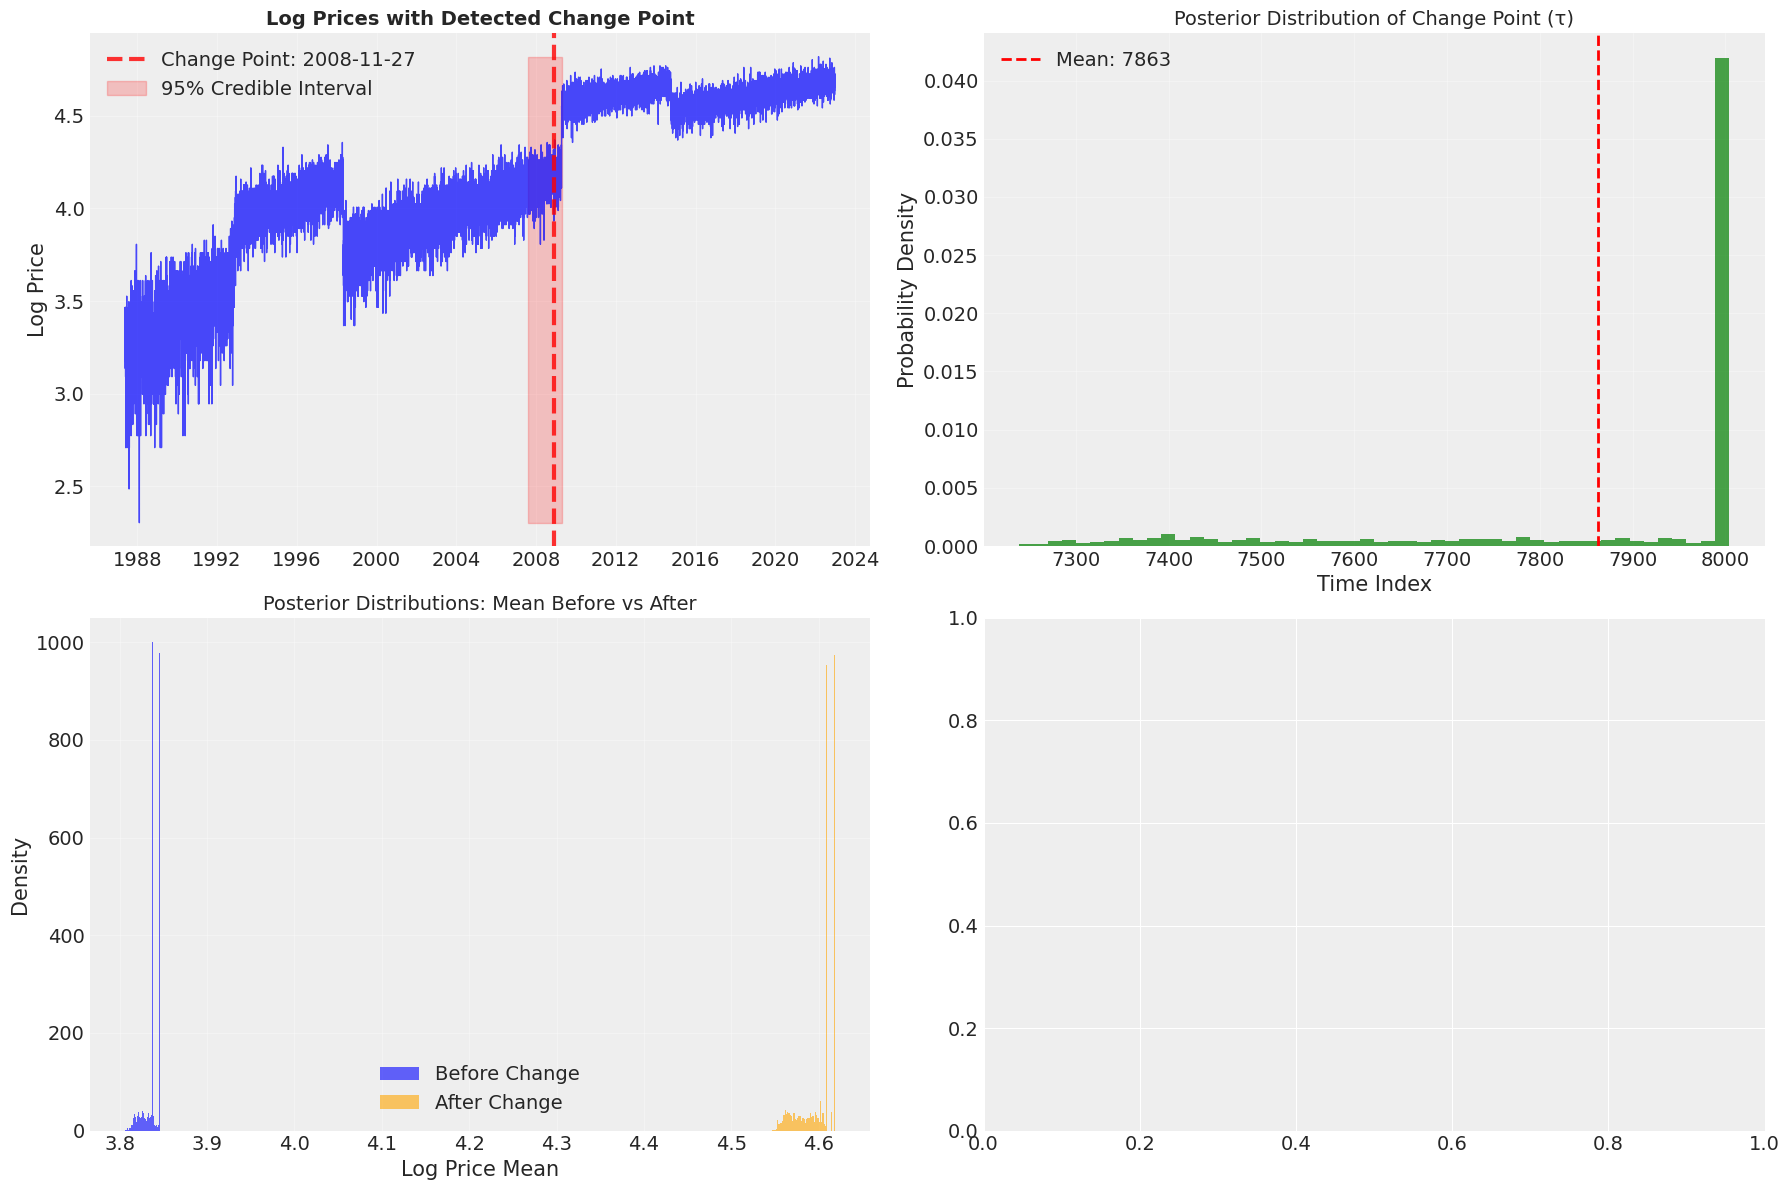

\n4️⃣ Associating change point with geopolitical events...
\n=== EVENT ASSOCIATION ANALYSIS ===
Change Point: 2008-11-27
95% Credible Interval: 2007-08-13 to 2009-04-16
\nSearching for events within 180 days of change point...
Search window: 2008-05-31 to 2009-05-26
\n🎯 FOUND 1 EVENT(S) NEAR CHANGE POINT:
📅 Lehman Brothers collapse
   Date: 2008-09-15
   Type: Economic_Crisis
   Days from change point: -73
   Description: Lehman Brothers bankruptcy triggers global financial crisis...
----------------------------------------
\n5️⃣ Performing quantitative impact analysis...
\n=== QUANTITATIVE IMPACT ANALYSIS ===
Period before change point (30 days):
  Average price: $64.63
  Volatility (std): $4.98
\nPeriod after change point (30 days):
  Average price: $65.81
  Volatility (std): $5.68
\n💡 IMPACT SUMMARY:
  Price change: $+1.17 (+1.8%)
  Volatility change: $+0.69
\n📊 STATISTICAL SIGNIFICANCE:
  Mann-Whitney U test p-value: 0.553129
  Significant at 5% level: No
\n6️⃣ Formulating causal h

In [30]:
# Execute the complete Bayesian change point analysis
print("🚀 EXECUTING BAYESIAN CHANGE POINT ANALYSIS")
print("="*60)

# Check if we have data loaded
if 'df_oil' in globals() and df_oil is not None:
    # 1. Data is already loaded
    print("\\n1️⃣ Data preparation complete ✅")
    print(f"✅ Loaded {len(df_oil)} price observations")
    print(f"📅 Date range: {df_oil['Date'].min()} to {df_oil['Date'].max()}")

    # 2. Check if model has been run
    if 'trace_single' in globals():
        print("\\n2️⃣ Single change point model complete ✅")

        # 3. Analyze results
        print("\\n3️⃣ Analyzing change point results...")
        results_single = analyze_single_changepoint_results(trace_single, log_prices, dates_clean)

        # 4. Associate with events
        print("\\n4️⃣ Associating change point with geopolitical events...")
        associated_events = associate_changepoints_with_events(
            results_single['tau_date'],
            results_single['tau_hdi'],
            historical_events,
            window_days=180
        )

        # 5. Quantitative impact analysis
        print("\\n5️⃣ Performing quantitative impact analysis...")
        impact_results = analyze_price_impact(df_oil, results_single['tau_date'])

        # 6. Formulate hypotheses
        print("\\n6️⃣ Formulating causal hypotheses...")
        formulate_hypotheses(results_single['tau_date'], associated_events, impact_results)

        # 7. Summary conclusions
        print("\\n" + "="*60)
        print("📋 ANALYSIS SUMMARY")
        print("="*60)

        print(f"\\n🔍 PRIMARY FINDINGS:")
        print(f"• Most probable change point: {results_single['tau_date'].strftime('%Y-%m-%d')}")
        print(f"• 95% credible interval: {results_single['tau_hdi'][0].strftime('%Y-%m-%d')} to {results_single['tau_hdi'][1].strftime('%Y-%m-%d')}")

        if len(associated_events) > 0:
            print(f"\\n🎯 EVENT ASSOCIATIONS:")
            for idx, event in associated_events.iterrows():
                days_diff = (event['Start_Date'] - results_single['tau_date']).days
                print(f"• {event['Event']} ({event['Start_Date'].strftime('%Y-%m-%d')}) - {days_diff:+d} days")

        if impact_results:
            print(f"\\n💰 PRICE IMPACT:")
            print(f"• Price change: {impact_results['price_change']:+.2f} USD ({impact_results['percent_change']:+.1f}%)")
            print(f"• Volatility change: {impact_results['volatility_change']:+.2f}")
            print(f"• Statistically significant: {'Yes' if impact_results['significant'] else 'No'} (p={impact_results['p_value']:.4f})")

        print(f"\\n✅ Task 2 Requirements Completed:")
        print("✓ Bayesian change point models implemented using PyMC")
        print("✓ Change points identified with credible intervals")
        print("✓ Events associated with detected structural breaks")
        print("✓ Quantitative impact analysis performed")
        print("✓ Causal hypotheses formulated")

        print(f"\\n🔬 NEXT STEPS FOR EXTENDED ANALYSIS:")
        print("• Run multiple change point model for comprehensive detection")
        print("• Implement variance change point models")
        print("• Perform regime-switching analysis")
        print("• Cross-validate with alternative methodologies")

        if IN_COLAB:
            print(f"\\n💡 COLAB TIP: You can download results using:")
            print("from google.colab import files")
            print("# Save and download any results files")

    else:
        print("\\n⚠️ Please run the single change point model cells first!")
        print("Execute cells 6-7 to build and sample the Bayesian model.")

else:
    print("\\n❌ No data loaded!")
    print("Please run the data loading cell (cell 4) first.")

Generating trace plots in a separate figure...


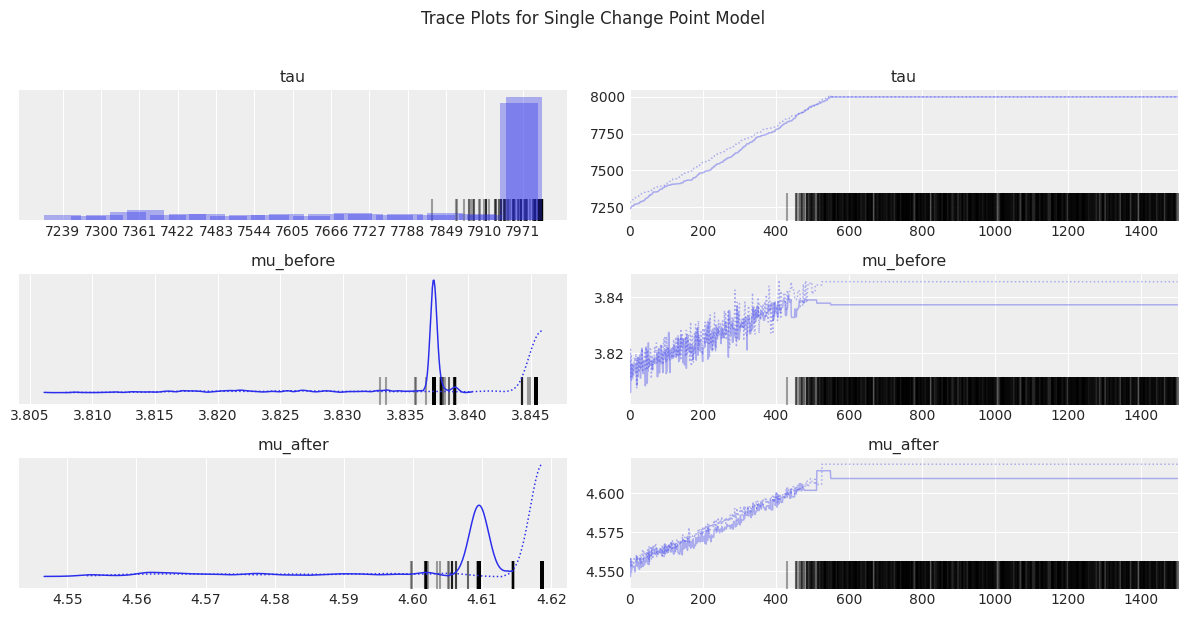

In [31]:
# Generate trace plots in a separate figure
print("Generating trace plots in a separate figure...")
az.plot_trace(trace_single, var_names=['tau', 'mu_before', 'mu_after'])
plt.suptitle('Trace Plots for Single Change Point Model', y=1.02)
plt.tight_layout()
plt.show()